# Aprendizaje en el ambiente Minigrid

Daniel Silva Contreras

Este archivo contiene el código utilizado para explorar la forma en la que el ambiente MiniGrid entrega los datos observados por el agente y posteriormente el aprendizaje mediante Q-Learning.
Hay funciones que se dejan como evidencia de las opciones que se exploraron pero al final no funcionaron como se esperaba, por tanto no las ocupa el código final.

Al final hay código para documentar la tabla Q en un archivo h5 y el experimento en formato de video.
Se usaron dos ambientes: vacío y cruce de lava.
El archivo tiene los últimos experimentos realizados que son con el ambiente más complejo de lava. En los comentarios se pueden ver los nombres de los otros ambientes que se probaron.

Los experimentos de desempeño de la tabla Q, se realizaron en otro archivo que se encuentra en el mismo repositorio que este.

In [6]:
import numpy as np
import gym
import gym_minigrid

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Prueba 1: cargar el ambiente y realizar una acción

El ambiente regresa 4 cosas: un arreglo de 7x7x3 con la observación del agente, la recompensa, una bandera para indicar si el episodio ha terminado y una cadena con información adicional.

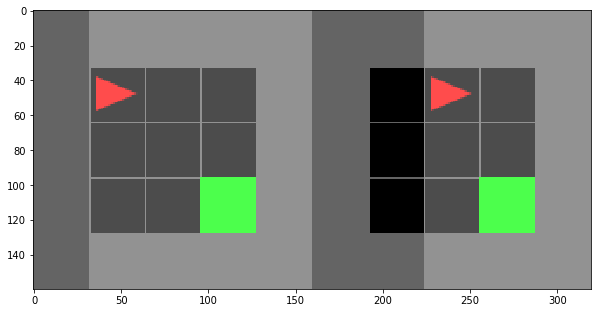

In [8]:
env = gym.make('MiniGrid-Empty-5x5-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1));

Prueba 2: visualizar datos de regreso del ambiente

Observation: {'image': array([[[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'direction': 1, 'm

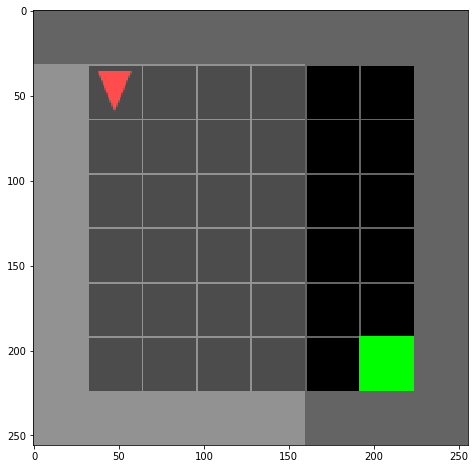

In [9]:
env = gym.make('MiniGrid-Empty-8x8-v0')
env.reset()
action = env.actions.right
obs, reward, done, info = env.step(action)
img = env.render('rgb_array')

print('Observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img);

Función para obtener el estado en términos de los ID de los objetos observables

In [10]:
#Regresa el estado observable expresado como los ID de los objetos
#Regresa el ID y key del objeto que tiene enfrente el agente.
def conv_state(state):
    col=[];row=[]
    for c in state:
        col=[]
        for r in c:
            obj=r[0]
            col.append(obj)
        row.append(col)
    front_obj = row[3][5]
    state=front_obj
    obj_str=list(gym_minigrid.minigrid.OBJECT_TO_IDX.keys())[front_obj]
    return row,state,obj_str

El estado representado como ocupación de casillas no aporta suficiente información, solo permite evitar obstáculos, pero no necesariamente llegar al objetivo. Con esta representación se tienen 8 estados, dado que se ocupa una representación binaria.

In [11]:
#Regresa el estado observable expresado como la ocupación de las casillas, adelante izuiqerda y derecha
def conv_state2(state):
    col=[];row=[]
    for c in state:
        col=[]
        for r in c:
            obj=r[0]
            col.append(obj)
        row.append(col)
    front_obj = row[3][5]
    right_obj = row[4][6]
    left_obj = row[2][6]
    d1=1 if (left_obj!=1)else 0
    d2=1 if (front_obj!=1)else 0
    d3=1 if (right_obj!=1)else 0
    state = d3*4 + d2*2 + d1
    obj_str=list(gym_minigrid.minigrid.OBJECT_TO_IDX.keys())[front_obj]
    return row,state,obj_str

Esta función utiliza la misma dinámica que la anterior, pero ahora se considera el tipo de objeto que hay en cada posición, dado que existen 11 posibles objetos, la representación del estado utiliza base 11. (1331 estados)
Se modificó para aceptar un valor más, correspondiente a si la posición ha sido visitada o no. Aunque para representar esto solo existen dos valores, se respeta la representación base 11. (2662 estados)

In [12]:
#Regresa el estado observable expresado de acuerdo a los posibles objetos adelante, a la derecha y a la izquierda
def conv_state3(state,vFlag):
    num_obj=11 # 11 posibles objetos por casilla = 11 x 11 x 11 = 1331
    col=[];row=[]
    for c in state:
        col=[]
        for r in c:
            obj=r[0]
            col.append(obj)
        row.append(col)
    front_obj = row[3][5]
    right_obj = row[4][6]
    left_obj = row[2][6]
    state = vFlag * (num_obj**3)+left_obj * (num_obj**2) + front_obj *(num_obj**1) + right_obj *((num_obj**0))
    obj_str=list(gym_minigrid.minigrid.OBJECT_TO_IDX.keys())[front_obj]
    return row,state,obj_str

Prueba 3: Orden de los datos regresados por las funciones anteriores
Este bloque se usó para hacer pruebas individuales de las funciones y asegurar el correcto ordenamiento de los datos.

Front ID: 1   Str: empty
Left: 1 Front: 1 Right 2 Sum: 4


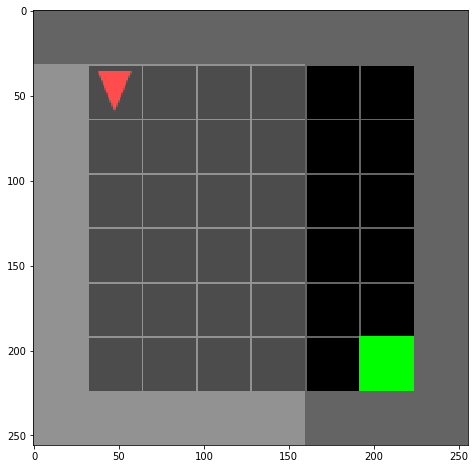

In [13]:
env.reset()      
action = env.actions.right
obs, reward, done, info = env.step(action)

img = env.render('rgb_array')
plt.imshow(img)

obs_img=obs['image']
obs_dir=obs['direction']

new_state, front, frontStr = conv_state2(obs_img)
front_obj = new_state[3][5]
right_obj = new_state[4][6]
left_obj = new_state[2][6]
sum_obj = left_obj + front_obj + right_obj
print("Front ID:",front_obj,"  Str:",frontStr)
print("Left:",left_obj,"Front:",front_obj,"Right",right_obj,"Sum:",sum_obj)


## Q-learning 

Primero se definen los pasos que requiere el Q-Learning para funcionar con fines ilustrativos, posteriormente se escriben funciones que uasn sus propios parámetros y permiten mayor flexibilidad.

Se decidió utilizar Q-Learning y no DQN, porque la observavilidad es parcial. De tener observavilidad completa, podría usarse DQN, aunque la red asociaría las posiciones con decisiones y sería problemático para pruebas en otros ambientes. Lo que se busca es que la experiencia en un ambiente permita al agente completar la tarea en otros ambientes con los mismos objetos. Para lograr esto se busca aprender de las interacciones con los objetos que rodean al agente y no cómo es la solución específica de un solo ambiente.

Por otro lado, DQN es más lento, al ser dos modelos que se actualizan cada cierto número de épocas. Y como ya se mencionó no puede generalizar en observavilidad parcial. Si se ocupa una representación más abstracta, como el ID del objeto en cada casilla que rodea al agente (frente, izquierda, derecha), la información de entrada es reducida como para pensar en las redes convolucionales del DQN.

In [14]:
import numpy as np
import gym
import gym_minigrid
import random
import time
from IPython.display import clear_output

Creación de un ambiente

In [15]:
env = gym.make('MiniGrid-Empty-8x8-v0')

Creación de la Tabla Q, con 0s

In [16]:
action_space_size = env.action_space.n
state_space_size = 1331 # considera la representacion base 11
print("Action space size:",action_space_size,"\nState  space size:",state_space_size)
q_table=np.zeros((state_space_size,action_space_size))
print(q_table.shape)

Action space size: 7 
State  space size: 1331
(1331, 7)


Parámetros para el aprendizaje

Se define el número máximo de épocas, y de pasos por episodio. El máximo es 100 porque el ambiente activa la bandera *done* cuando se llega a la iteración 100 independientemente de si se llegó o no a la meta. Por tanto no es posible hacer que el agente intente más pasos.

La tasa de aprendizaje se dejó como en los ejemplos consultados en deeplizard.com que a su vez es lo que recomienda la literatura como punto de partida.

La tasa de descuento es que tanto van a influir los valores futuros de Q en el aprendizaje. Su valor debe estar entre 0 y 1. Se dejó ligeramente abajo porque se desea que el agente busque una recompensa mayor en estados futuros y no trate de explotar solo las recompansas inmediatas.

In [17]:
num_episodes=10000
max_steps_per_episode=100
learning_rate=0.1
discount_rate=0.98

Función para buscar pasillos en el estado observable. Regresa la posición de los pasillos tanto horizontales como verticales.

Parece no resultar de mucha utilidad porque es demasiado específico, las políticas basadas en la ubicación de características concretas no han dado buenos resultados

In [18]:
def search_hall(state):
    # Revisa si hay pasillos
    hall_v=[]
    hall_h=[]
    s=np.array(state)
    count_hallsv = np.count_nonzero(s==1,axis=1)
    count_hallsh = np.count_nonzero(s==1,axis=0)
    for element in count_hallsv:
        if (element==1):
            i=np.where(count_hallsv==element)[0][0]
            j=np.where(s[i]==element)[0][0]
            if(6 > i > 0):
                hall_v=[i,j]
            break
    for element in count_hallsh:
        if (element==1):
            i=np.where(count_hallsh==element)[0][0]
            j=np.where(s[:,i]==element)[0][0]
            if(6 > j > 0):
                hall_h=[j,i] # están al revés para traducirlo al marco coordenado del agente
            break         
    return hall_v, hall_h 

Función para determinar que tan lejos están los pasillos observados en cada dimensión.

Esto tiene sentido para dos pasillos, pero cuando hay zonas similares a un laberinto, es decir zonas muy estrechas, no aporta nada al aprendizaje y vuelve al agente avaro, provocando que oculte y descubra pasillos reiteradamente para ganar una mayor recompensa

In [19]:
def distance_hall(old_hall,new_hall):
    distances=[-100,-100]
    for element in old_hall:
        dist=-1
        if(element!=[]):
            x1=element[0]
            y1=element[1]
            i=old_hall.index(element)
            if (new_hall[i]!=[]):
                x2=new_hall[i][0]
                y2=new_hall[i][1]
                dist=(x2-x1)+(y2-y1)
            else:
                dist=0 # perdió de vista el pasillo
            distances[i]=dist
        else:
            i=old_hall.index(element)
            if(new_hall[i]!=[]):
                distances[i]=10 #pasillo encontrado
    return distances

Función que indica la presencia o ausencia del objeto *objetivo*

In [20]:
def isGoalpresent(state):
    s=np.array(state)
    result=np.where(s==8)
    if(result[0].size > 0):
        present=True
    else:
        present=False
    return present

In [21]:
def get_position(observation,action, position):
    dir=observation['direction']
    x=0;y=0;
    nx=position[0]
    ny=position[1]
    if (action==2): #forward
        if (dir==0):
            y=1
        elif (dir==1):
            x=1
        elif (dir==2):
            y=-1
        else:
            x=-1
        if((nx+x)>=0):
            nx+=x
        if((ny+y)>=0):
            ny+=y
    return [nx,ny]

In [22]:
def mapping(position, map_list):
    nmap=[]
    nx=position[0]
    ny=position[1]
    if not[nx,ny] in map_list:
        map_list.append([nx,ny])
        nmap=map_list
    else:
        nmap=map_list
    return nmap

In [23]:
def pos_visited(position,map_list):
    if position in map_list:
        return True
    else:
        return False

Pruebas individuales de las funciones usadas anteriormente.

In [24]:
test_state=[[2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
test_state2=[[2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
goalp=isGoalpresent(test_state)
print(goalp)

False


Función de recompensa que sobreescribe a la función del ambiente.

La idea es dar una recompensa por acción. Lo primero que se hace es penalizar las acciones que no tienen sentido, como intentar recoger un objeto en una casilla vacía, después se usa una representación de lo que el agente tiene a izquierda y derecha para que no se meta en caminos sin salida, explore pasillos y evite obstáculos. Finalmente se otrogan recompensas si descubre pasillos. Esta última condición ha demostrado no ser útil.

In [66]:
def fun_reward(last_state, current_state, action, creward, position, map_list):
    USE_HALL_CONDITION=False
    USE_THREE_POSITION=True
    USE_VISITED_POSITION=True
    actionObject=0
    d_reward=0
    p_reward=0
    v_reward=0
    
    left_pos =current_state[2][6]
    front_pos=current_state[3][5]
    right_pos=current_state[4][6]
    
    lleft_pos =last_state[2][6]
    lfront_pos=last_state[3][5]
    lright_pos=last_state[4][6]
    goal_present=isGoalpresent(current_state)
    
    # Restringe acciones
    in_obj=current_state[3][6] # Objeto sobre el que se encuentra el agente
    if (lfront_pos==0 or lfront_pos==1 or lfront_pos==3 or lfront_pos==8) and (action>=3 and action<=5): 
        actionObject =- 2
    elif (in_obj==8 and action==6):
        actionObject = 1
    elif (in_obj!=8 and action==6):
        actionObject =- 3
    else:
        actionObject=0
      
    #Posición visitada?
    if (USE_VISITED_POSITION==True):
        if (pos_visited(position,map_list)):
            v_reward=-0.1
        else:
            v_reward=0.1
        
    # usa una representación de lo que tiene el agente a la izquierda y derecha
    if (USE_THREE_POSITION==True):
        if((lfront_pos==2 or lfront_pos==6 or lfront_pos==9 or lfront_pos==10) and action==2 ):
            p_reward = -1
        elif(lfront_pos==1 and action==2 and v_reward<0):
            p_reward = -0.01 #Funciona: -0.01
        elif(lfront_pos==1 and action==2 and v_reward>0):
            p_reward = 0.01 # Funciona: 0.01

#        if(front_pos==1): # adelante libre
#            p_reward += 0.001
#        elif(right_pos!=1 and left_pos!=1 and front_pos!=1 and front_pos!=8): #sin salida
#            p_reward += -0.01
#        elif(lright_pos!=1 and lleft_pos!=1 and lfront_pos==1 and action==2 and v_reward<0 ): #pasillo
#            p_reward += 0.001
#        elif((lfront_pos==2 or lfront_pos==6 or lfront_pos==9 or lfront_pos==10) and action==2 ): # wall or ball or lava or other agent
#            p_reward += -0.01
#        else:
#            p_reward = 0;
        
    # Pasillos No usar, no funciona
    if ((goal_present==False) and (USE_HALL_CONDITION==True)):
        last_hall=search_hall(last_state)
        current_hall=search_hall(current_state)
        hall_change=distance_hall(last_hall,current_hall)
        for d in hall_change:         
            if (d!=-100):
                if (d==10):
                    d_reward=0.1
                else:
                    d_reward+=d/100
                    
    if (actionObject!=0):
        return actionObject
    else:
        return p_reward + creward   

Función de entrenamiento del agente Q

In [26]:
def train_Q(env_name,num_episodes,max_steps,learning_rate,discount_rate,exploration_decay_rate):
    env = gym.make(env_name)
    action_space_size = env.action_space.n
    state_space_size = 2662 # 2 x 11 x 11 x 11
    
    print("Training...\n")
    q_table=np.zeros((state_space_size,action_space_size))
    stats={'rew':[]}
    
    exploration_rate=1
    max_exploration_rate=1
    min_exploration_rate=0.01
    rewards_all_episodes=[]
    episode_rewards=[]
    
    map_grid=[]
    position=[0,0]
    map_grid.append(position)
    
    #Q learning algorithm
    convergence = False
    last=-1000
    rewards_current_episode = 0
    for episode in range(num_episodes):
        completeState,state,stateStr=conv_state3(env.reset()['image'],0)
        last_state=completeState
        done = False
        episode_rewards.append(rewards_current_episode/num_episodes) #stats
        rewards_current_episode = 0
        map_grid=[]
        position=[0,0]
        map_grid.append(position)
        for step in range(max_steps):
            # Exploration-explotation trade-off
            exploration_rate_threshold=random.uniform(0,1)
            if exploration_rate_threshold > exploration_rate:
                action=np.argmax(q_table[state,:])
            else:
                action=env.action_space.sample()

            new_state,env_reward,done,info=env.step(action)

            position=get_position(new_state,action,position)     # Calcula la posición
            visitedFlag=pos_visited(position,map_grid)
            completeState, newState, newStr=conv_state3(new_state['image'],visitedFlag)
            
            # position,map_grid=mapping(new_state,action,position,map_grid) 
            position=get_position(new_state,action,position)     # Calcula la posición
            
            #print("Position:",position," Map_grid:",map_grid)
            reward = fun_reward(last_state,completeState,action,env_reward, position, map_grid)
            
            map_grid=mapping(position,map_grid)                  # mapea el recorrido del agente
            
            # Update Q-table  for Q(s,a)
            q_table[state,action]=q_table[state,action] * (1- learning_rate) + \
            learning_rate*(reward+discount_rate*np.max(q_table[newState,:]))

            state=newState
            last_state=completeState
            rewards_current_episode+=reward
            if done==True:
                break            

        exploration_rate=min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
        rewards_all_episodes.append(rewards_current_episode)
        
        if(((episode+1) >= 1000) and ((episode+1) % 1000 == 0)):
            rewards_per_thousand_episodes= np.split(np.array(rewards_all_episodes),int((episode+1)/1000))
            
            avg=[]
            for r in rewards_per_thousand_episodes:
                avg.append(sum(r/1000))
            dif = abs(last-avg[len(avg)-1])
            if(dif <= 0.0001):
                convergence = True
            last=avg[len(avg)-1]
            print("Episode",episode+1,": Reward:{:.5f}\t".format(avg[len(avg)-1]), \
                  "Change: {:.5f}".format(dif)) #, \
#                  "State 342:",np.argmax(q_table[342]), \
#                  "--> {:.3f}".format(q_table[342][0]), \
#                  "{:.3f}".format(q_table[342][1]), \
#                  "{:.3f}".format(q_table[342][2]))
                
        if (convergence == True):
            break
    stats['rew']=episode_rewards;
    print("\nDone\n")
    return stats,q_table

Training...

Episode 1000 : Reward:-2.457911	 Change: 997.54209
Episode 2000 : Reward:0.413366	 Change: 2.87128
Episode 3000 : Reward:0.837031	 Change: 0.42366
Episode 4000 : Reward:0.916560	 Change: 0.07953
Episode 5000 : Reward:0.934945	 Change: 0.01838
Episode 6000 : Reward:0.942603	 Change: 0.00766
Episode 7000 : Reward:0.947475	 Change: 0.00487
Episode 8000 : Reward:0.947542	 Change: 0.00007

Done



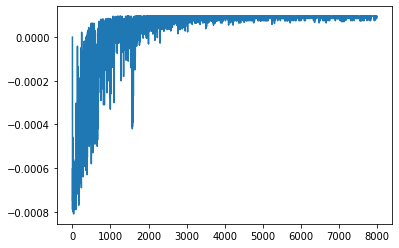

In [199]:
st, q_table = train_Q(env_name = 'MiniGrid-Empty-8x8-v0',
                  num_episodes = 10000,
                  max_steps = 100,
                  learning_rate = 0.1,
                  discount_rate = 0.98,
                  exploration_decay_rate = 0.001)
plt.plot(range(len(st['rew'])),st['rew'])
plt.show()

Entrenamiento para **escenario de Lava**. La configuración del pasillo de lava es aleatoria en cada iteración.

Training...

Episode 1000 : Reward:-43.93210	 Change: 956.06790
Episode 2000 : Reward:-16.29694	 Change: 27.63516
Episode 3000 : Reward:-7.25133	 Change: 9.04561
Episode 4000 : Reward:-3.03184	 Change: 4.21949
Episode 5000 : Reward:-1.62002	 Change: 1.41182
Episode 6000 : Reward:-1.01172	 Change: 0.60830
Episode 7000 : Reward:-0.98970	 Change: 0.02202
Episode 8000 : Reward:-0.89239	 Change: 0.09731
Episode 9000 : Reward:-0.83998	 Change: 0.05241
Episode 10000 : Reward:-0.74521	 Change: 0.09477

Done



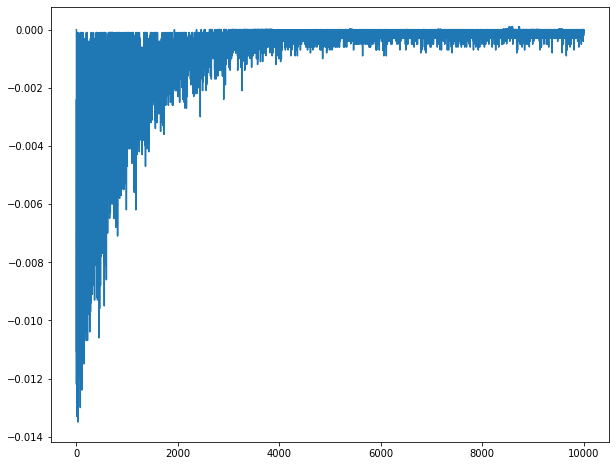

In [63]:
st2,q_table2 = train_Q(env_name = 'MiniGrid-LavaCrossingS9N1-v0', #MiniGrid-LavaCrossingS9N3-v0
                  num_episodes = 10000,
                  max_steps = 100,
                  learning_rate = 0.1,
                  discount_rate = 0.98,
                  exploration_decay_rate = 0.001)
#print("Action =",np.argmax(q_table2[342])) # ," ".join('{:6.3f}'.format(k) for k in q_table2[342]))
plt.plot(range(len(st2['rew'])),st2['rew'])
plt.show()

In [65]:
# Test with the learned Q-table
# %matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

env_name='MiniGrid-LavaCrossingS11N5-v0' #'MiniGrid-LavaCrossingS11N5-v0'
#env_name='MiniGrid-Empty-8x8-v0'
env = gym.make(env_name)
TEST_STEPS = 100
cState, state, stateStr = conv_state3(env.reset()['image'],0)
images=[]
images.append(env.render('rgb_array'))
actions=[]
states=[]
states.append(state)
map_grid=[]
position=[0,0]
map_grid.append(position)

print("Simulation in progress...")

for step in range(TEST_STEPS):
    action=np.argmax(q_table2[state,:])
    actions.append(action)
    
    new_state,reward,done,info=env.step(action)
    
    position=get_position(new_state,action,position)     # Calcula la posición
    visitedFlag=pos_visited(position,map_grid)
    
    cState, newState, newStr=conv_state3(new_state['image'],visitedFlag)
    map_grid=mapping(position,map_grid)                  # mapea el recorrido del agente
    
    states.append(newState)
    state=newState
    
    img = env.render('rgb_array')
    images.append(img)
    if done == True:
        break
        
print("Simulation done. \nBuilding video...")

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(images)):
    im = plt.imshow(images[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=2000)
plt.close()
HTML(ani.to_html5_video())

Simulation in progress...
Simulation done. 
Building video...


In [68]:
ani.save('./video/LavaCrossing1_objetivo13__v7.mp4', writer='ffmpeg', fps=10, dpi=100)

In [29]:
print(states)
print(actions)
for i in range(len(q_table2)):
    case_Q = q_table2[i]
    if(sum(case_Q)!=0):
        print("sum:",i,"Action:",np.argmax(case_Q)," Q:"," ".join('{:6.3f}'.format(k) for k in case_Q))

[262, 262, 262, 254, 262, 262, 273, 1673, 2433, 2433, 2433, 1465, 1464, 1109, 133, 1464, 1101, 1101, 1112, 1585, 254, 254, 331, 265]
[2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2]
sum: 133 Action: 0  Q:  0.766  0.412  0.365 -1.515 -1.460 -1.489 -2.503
sum: 134 Action: 0  Q:  0.759  0.225  0.317 -1.672 -1.728 -1.618 -2.638
sum: 141 Action: 1  Q:  0.106  0.700  0.134 -1.554 -1.449 -1.338 -2.236
sum: 144 Action: 1  Q:  0.368  0.813 -0.645  0.342  0.345  0.291 -2.570
sum: 145 Action: 1  Q:  0.189  0.772 -0.619  0.096  0.138  0.088 -2.187
sum: 151 Action: 5  Q:  0.056  0.119 -0.093  0.334  0.003  1.509 -0.901
sum: 152 Action: 1  Q:  0.070  0.437 -0.584  0.025  0.059  0.065 -1.792
sum: 211 Action: 0  Q:  0.026  0.000  0.000  0.000  0.000 -0.090  0.000
sum: 221 Action: 0  Q:  0.679  0.250 -0.670  0.291  0.289  0.281 -2.668
sum: 222 Action: 3  Q:  0.004  0.003 -0.184  0.104  0.000  0.000 -0.812
sum: 254 Action: 2  Q:  0.583  0.728  0.752 -1.118 -1.148 -1.192 -2.125
sum: 

Guarda la Tabla Q en un archivo .h5

In [31]:
import h5py
hf = h5py.File('qTableLavaV3.h5', 'w')
hf.create_dataset('qTableLava', data=q_table2)
hf.close()

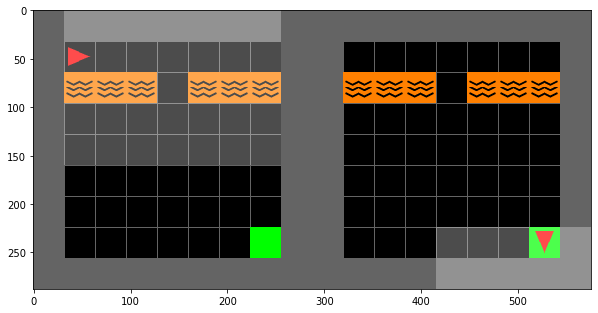

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate([images[0], images[len(images)-1]], 1));